# Test Inspections

In [1]:
# General imports
import os
import sys
import gc
from datetime import datetime
from pprint import pprint
import time
import pickle
import random

# Custom Functions
sys.path.append(os.path.abspath('../Notebooks/Utilities')) 
import cust_utilities as utils

# Maths, Pandas etc
import math
import numpy as np
import pandas as pd
import scipy as sci

# Plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.backends.backend_pdf import PdfPages

# MNE-Python
import mne
from mne.preprocessing import ICA
from mne_icalabel import label_components
from autoreject import AutoReject
from autoreject import get_rejection_threshold

# # SpecParam
# from specparam import SpectralGroupModel
# from specparam.plts.spectra import plot_spectra
# from specparam import __version__ as specparam_version
# print('Current SpecParam version:', specparam_version)


In [ ]:
# Function to plot EEG Time Series
#

def plot_EEG_TD(eeg_FIF, channels, time_range_s=[], pdf_file = None):
    
    """
    EEG Time Domain Plot.

    Parameters
    ----------
    eeg_FIF : FIF
    channels : [str] eg ['P5', 'Pz']
    time_range_s : [nn,nn]
    """

    # Channels Limit
    max_plots = 5
    if len(channels) > max_plots:
        channels = channels[:max_plots]

    sfreq = eeg_FIF.info['sfreq']
    if time_range_s:
        start = int(time_range_s[0] * sfreq)
        stop = int(time_range_s[1] * sfreq)
    else:
        start = 0
        stop = None

    # Get signal and times for the elected channel(s)
    # Handle Epoched data
    if eeg_FIF.__class__.__name__.startswith('Raw'):
        signal, times = eeg_FIF.get_data(picks=channels, 
                                        start=start, stop=stop,
                                        return_times=True)
    else:
        signal, times = eeg_FIF.get_data(picks=channels,
                                        return_times=True)
    # signal, times = eeg_FIF.get_data(picks=channels, 
    #                                  start=start, stop=stop,
    #                                  return_times=True)

    # plot and copy to pdf
    plt.figure(figsize=(12, 8))
    for i, ch_name in enumerate(channels):
        plt.plot(times, signal[i] * 1e6, label=ch_name, alpha=0.7, linewidth=0.6)
    plt.title('EEG Time Series - Channels: ' + ', '.join(channels))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (µV)')
    plt.legend()
    plt.tight_layout()
    if pdf_file:
        pdf_file.savefig()
    plt.show()

In [3]:
# Chnage to use this?

def new_plot_EEG_TD(eeg_data, channels, start=0, stop=None, pdf_file=None):
    # Handle Raw and Epochs objects differently
    if hasattr(eeg_data, "get_data") and hasattr(eeg_data, "times"):
        if eeg_data.__class__.__name__.startswith("Raw"):
            # Raw object: can use start/stop
            data = eeg_data.get_data(picks=channels, start=start, stop=stop)
            times = eeg_data.times[start:stop]
        else:
            # Epochs object: get all data, then slice if needed
            data = eeg_data.get_data(picks=channels)  # shape: (n_epochs, n_channels, n_times)
            times = eeg_data.times
            # Optionally, slice times and data if start/stop are specified
            if stop is not None:
                data = data[..., start:stop]
                times = times[start:stop]
            elif start != 0:
                data = data[..., start:]
                times = times[start:]
    else:
        raise ValueError("Unsupported eeg_data type for plot_EEG_TD")
    # plotting code...

In [4]:
# Study Details

study_name = 'IOWA_Rest'
eeg_run_results_folder = 'EEG_Processing_ds004584-1.0.0_20250626_trial_preprocess'

# Get existing study details, if exists
study_folder_path = utils.get_folder_path('Study_' + study_name)
study_info_df = pd.read_pickle(study_folder_path + '/study_inf_df.pkl', compression='zip')
study_subjects_df = pd.read_pickle(study_folder_path + '/study_subjects_df.pkl', compression='zip')

# Get all folder paths from study_info_df

# Get previous run details
results_parent_path = study_info_df.loc[0, 'eeg_processing_results_path']

preprocess_results_folder = utils.extend_folder_path(results_parent_path, eeg_run_results_folder)
eeg_run_parameters_file_path = utils.get_file_path(preprocess_results_folder, 'eeg_run_params_df.pkl')


In [5]:
# Read in a FIF file with EEG data

raw_file_name = 'sub-026_source_raw.fif'
raw_file_path = utils.get_file_path(preprocess_results_folder, raw_file_name)
raw_source = mne.io.read_raw_fif(raw_file_path, preload=True, verbose='WARNING')
print(raw_source)
print(raw_source.info)

raw_file_name = 'sub-026_filtered_raw.fif'
raw_file_path = utils.get_file_path(preprocess_results_folder, raw_file_name)
raw_filtered = mne.io.read_raw_fif(raw_file_path, preload=True, verbose='WARNING')
print(raw_filtered)
print(raw_filtered.info)

###
# nb epochs.save()
# epochs = mne.read_epochs(raw_file_path, preload=True)
# raw_file_name = 'sub-026_cleaned_raw.fif'
# raw_file_path = utils.get_file_path(preprocess_results_folder, raw_file_name)
# raw_cleaned = mne.io.read_raw_fif(raw_file_path, preload=True, verbose='WARNING')
# print(raw_cleaned)
# print(raw_cleaned.info)


<Raw | sub-026_source_raw.fif, 63 x 71410 (142.8 s), ~34.4 MiB, data loaded>
<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, Iz, FC5, FC1, C3, T7, TP9, CP5, CP1, P3, P7, ...
 chs: 63 EEG
 custom_ref_applied: False
 dig: 66 items (3 Cardinal, 63 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 63
 projs: []
 sfreq: 500.0 Hz
>
<Raw | sub-026_filtered_raw.fif, 61 x 71410 (142.8 s), ~33.3 MiB, data loaded>
<Info | 11 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, Iz, FC5, FC1, C3, T7, TP9, CP5, CP1, P3, P7, ...
 chs: 61 EEG
 custom_ref_applied: True
 dig: 64 items (3 Cardinal, 61 EEG)
 file_id: 4 items (dict)
 highpass: 1.0 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 61
 projs: []
 sfreq: 500.0 Hz
>


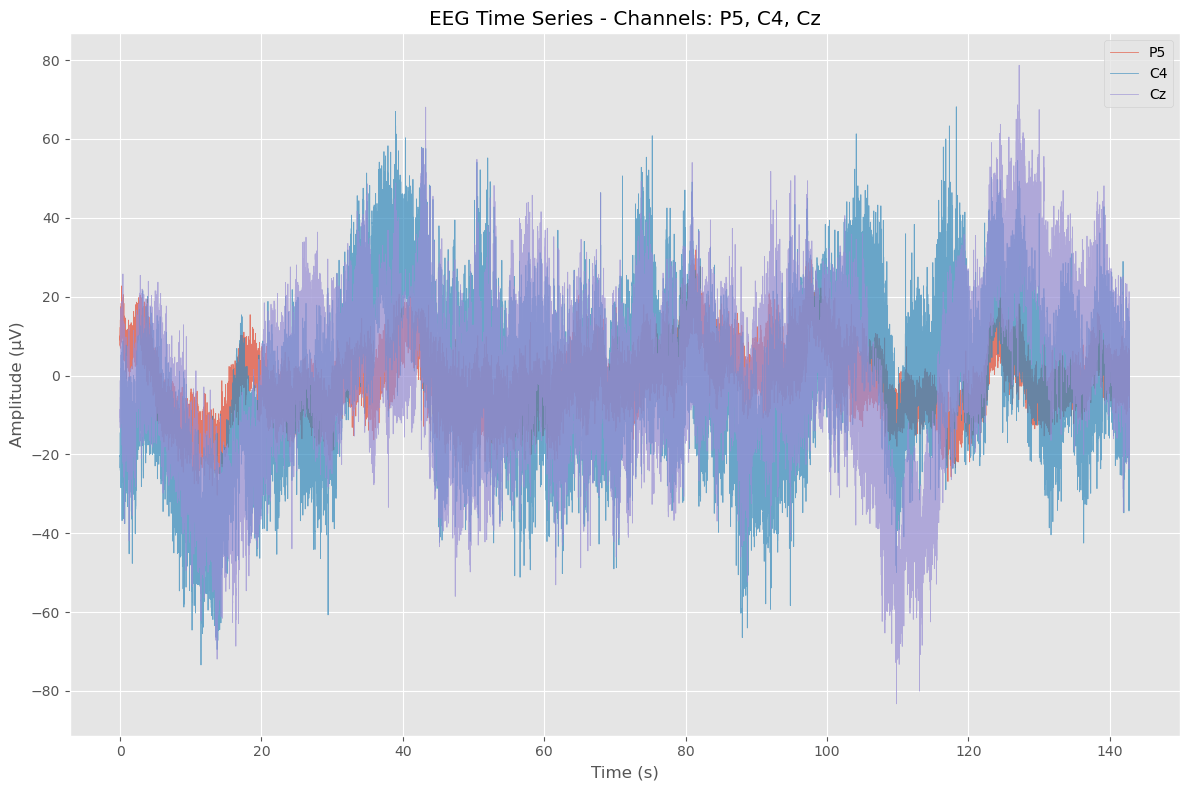

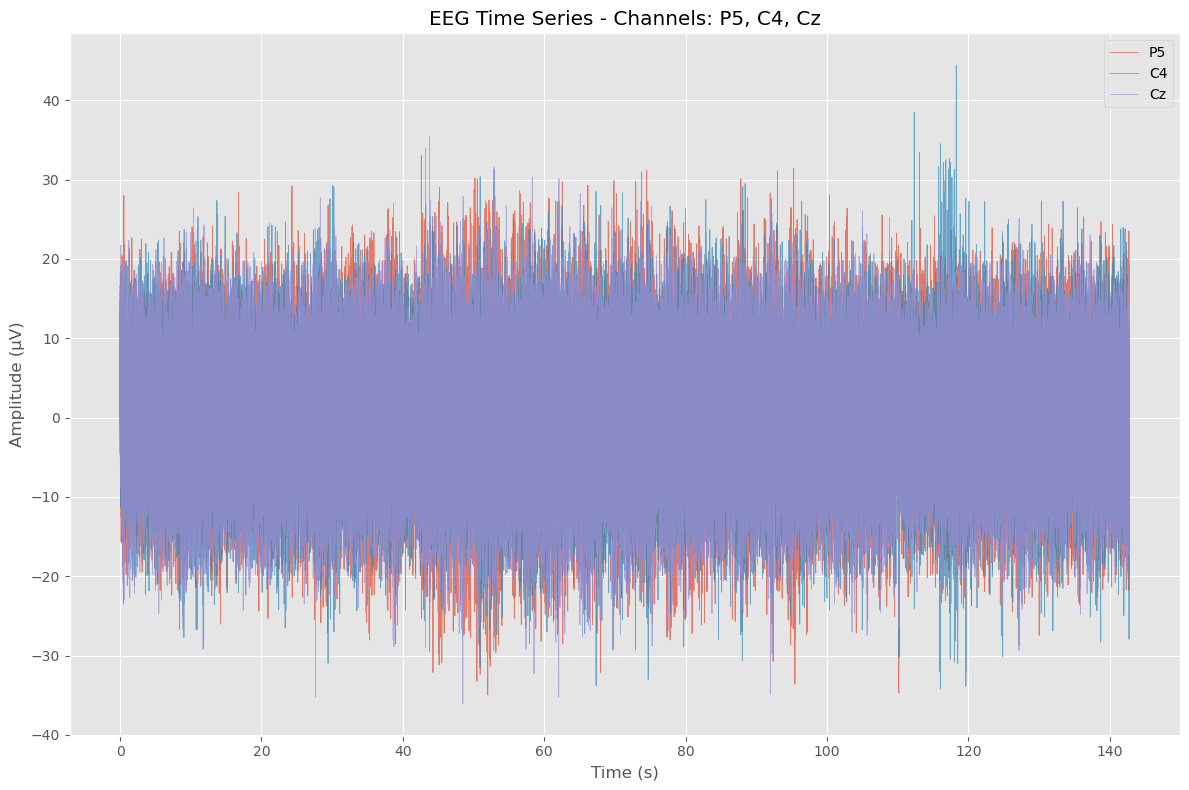

In [6]:
sample_channels = ['P5', 'C4', 'Cz']
plot_EEG_TD(raw_source, sample_channels)
plot_EEG_TD(raw_filtered, sample_channels)
# plot_EEG_TD(raw_cleaned, sample_channels)